In [1]:
import numpy as np, matplotlib.pyplot as plt, pymust

In [2]:
class SimulationWithMovement:
    def __init__(self, param, xScatters, zScatters, vScatters, RCScatters):
        self.param = param
        self.xScatters = xScatters
        self.zScatters = zScatters
        self.vScatters = vScatters
        self.RCScatters = RCScatters
        
    def simulate(self, nReps):
        for i in range(nReps):
            txdelay = pymust.txdelay(0, 5e-2, self.param)
            RF_new, _ = pymust.simus(self.xScatters, self.zScatters, self.RCScatters,  txdelay, self.param)
            self.zScatters += self.vScatters /self.param.PRF
            if i ==0:
                RFs = np.zeros([RF_new.shape[0], RF_new.shape[1], nReps])
                
            RFs[:, :, i] = RF_new
        return RFs
        



# Single scatterer

In [3]:
param = pymust.getparam('P4-2v')
param.Nelements = 1
xScatters= np.array([0, 0], dtype = float)
zScatters = np.array([5e-2, 6e-2]) #Need to introduce a second scatterer so that the recieved signal has a constant length
vScatters = np.array([1e-2, 0])
RCScatters = np.array([1, 0])

param.PRF = 1000 #PRF = 1lHz

nReps = 4

s1 = SimulationWithMovement(param, xScatters, zScatters, vScatters, RCScatters)


In [4]:
RFs = s1.simulate(nReps)
x = np.array([[0]])
z = np.array([[5e-2]])

IQs = np.stack([pymust.rf2iq(RFs[:,:,i], param.fs) for i in range(RFs.shape[-1])], axis = 2)
Mdas = pymust.dasmtx(IQs[:,:,0],x,z,param)
IQs_b = np.stack([ pymust.utils.applyDasMTX(Mdas, pymust.rf2iq(RFs[:,:,i], param.fs),(1,1) )for i in range(RFs.shape[-1])], axis = 2)

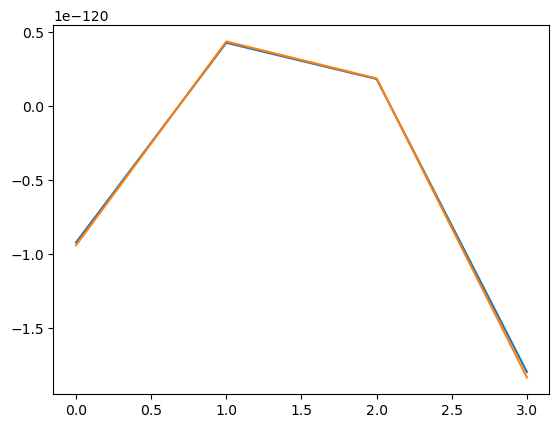

In [5]:
plt.plot(IQs_b[0,0,:].imag)
plt.plot(IQs_b[0,0,:].real)

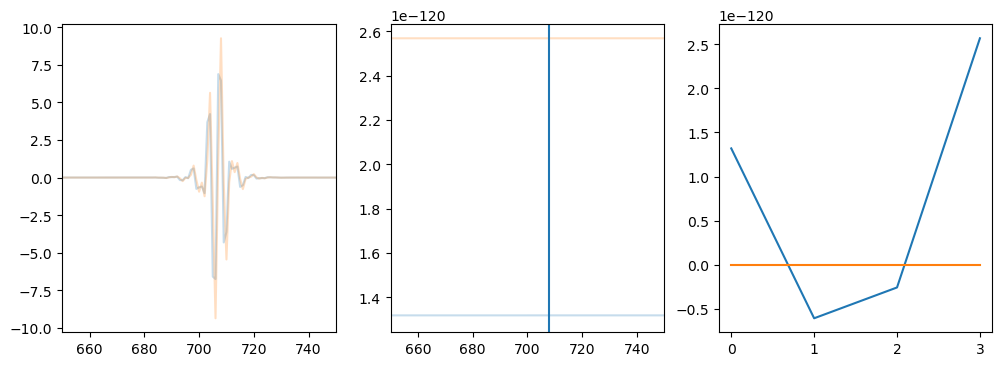

In [6]:
_, (f1,f2,f3) = plt.subplots(ncols = 3, figsize = (12, 4))
plt.sca(f1)
plt.plot(RFs[:,0,0], alpha = .25)
plt.plot(RFs[:,0,-1], alpha = .25)
plt.xlim (650,750)

plt.sca(f2)
plt.plot(np.abs(IQs[:,0,0]), alpha = .25)
plt.plot(np.abs(IQs[:,0,-1]), alpha = .25)
plt.xlim (650,750)
plt.axvline(708)

plt.sca(f3)
plt.plot(IQs[708, 0, :].real)
plt.plot(IQs[708, 0, :].imag)

In [7]:
pymust.iq2doppler(IQs_b, param)

(array([[-0.14154412]]), array([[0.00345517]]))

# Several scatterers

(array([116.,  99., 125., 126.,  34.,   0.,   0.,   0.,   0.,   1.]),
 array([0.04708518, 0.04937666, 0.05166814, 0.05395963, 0.05625111,
        0.05854259, 0.06083407, 0.06312555, 0.06541704, 0.06770852,
        0.07      ]),
 <BarContainer object of 10 artists>)

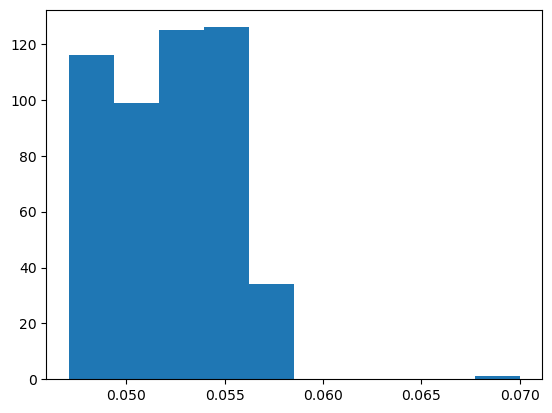

In [25]:
plt.hist(zScatters)

In [29]:
param = pymust.getparam('P4-2v')
param.TXnow = 4
#param.Nelements = 64
nScatters = 500 + 1

xScatters = np.zeros(nScatters)
zScatters = 5e-2 + (np.random.rand(nScatters) -.5) * 1e-2
vScatters = 0.1* np.ones(nScatters)
RCScatters = np.ones(nScatters) #+ np.random.rand(nScatters)
# Set the last as guardian
RCScatters[-1] = 0
vScatters[-1] = 0
zScatters[-1] = 7e-2

param.PRF = 1000 #PRF = 1lHz
sMany = SimulationWithMovement(param, xScatters, zScatters, vScatters, RCScatters)

nReps = 16
RFs = sMany.simulate(nReps)
x = np.array([[0]])
z = np.array([[5e-2]])

IQs = np.stack([pymust.rf2iq(RFs[:,:,i], param) for i in range(RFs.shape[-1])], axis = 2)
Mdas = pymust.dasmtx(IQs[:,:,0],x,z,param)
IQs_b = np.stack([ pymust.utils.applyDasMTX(Mdas, IQs[:,:,i],(1,1) )for i in range(RFs.shape[-1])], axis = 2)
pymust.iq2doppler(IQs_b, param, lag = 1)

(array([[-0.09293035]]), array([[0.00040083]]))

In [34]:
RF = RFs[:,:,0]

nl = RF.shape[0]
#% Keep a maximum of 100 randomly selected scanlines
Nc = RF.shape[1]
if Nc<100:
        idx = np.arange(Nc)
else:
    idx = np.random.permutation(Nc)[:100]
#% Power Spectrum
P = np.linalg.norm(np.fft.rfft(RF[:,idx], axis = 0),axis =1)
freqs = np.fft.rfftfreq(RF.shape[0],1/Fs)
#% Carrier frequency
Fc = np.sum(freqs*P)/np.sum(P)

Fc/ param.fc

0.9755487061919179

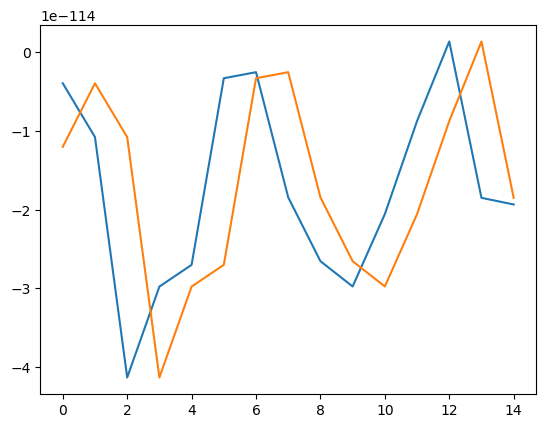

In [26]:
plt.plot(IQs_b[0,0,1:])
plt.plot(IQs_b[0,0,:-1])

In [14]:
IQ1 = IQs_b[:,:,: -1]
IQ2 = IQs_b[:,:,1:]

AC = np.sum(IQ1*np.conj(IQ2),2)  # ensemble auto-correlation
AC, np.angle(AC)

(array([[5.13614135e-227-1.25965409e-228j]]), array([[-0.02452038]]))

In [15]:
param.c*param.PRF/4/param.fc/1

0.14154411764705882

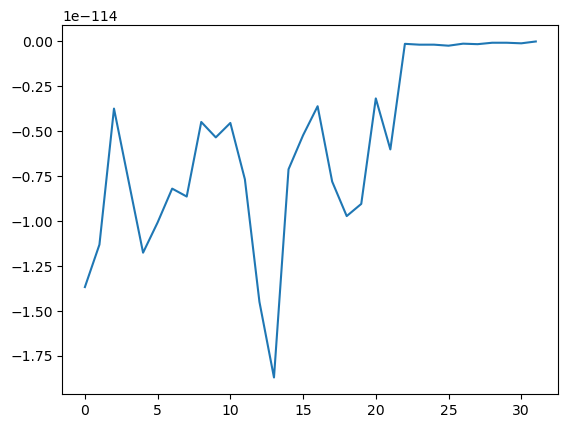

In [16]:
plt.plot(IQs_b[0,0,:].real)

In [17]:
vScatters

array([0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14,
       0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14,
       0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14,
       0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14,
       0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14,
       0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14,
       0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14,
       0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14,
       0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14,
       0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14,
       0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14,
       0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14,
       0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14,
       0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.

(650.0, 750.0)

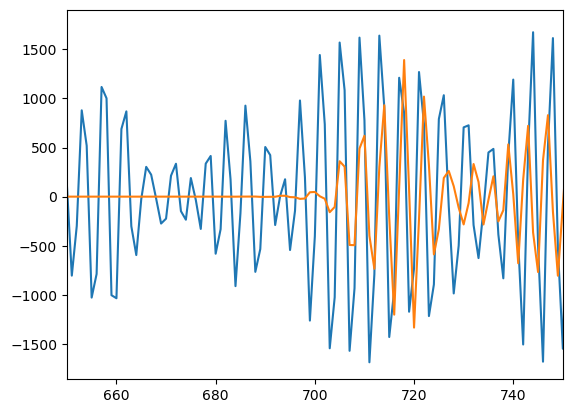

In [18]:
plt.plot(RFs[:, 0, 0])
plt.plot(RFs[:, 0, -1])
plt.xlim(650, 750)

(650.0, 750.0)

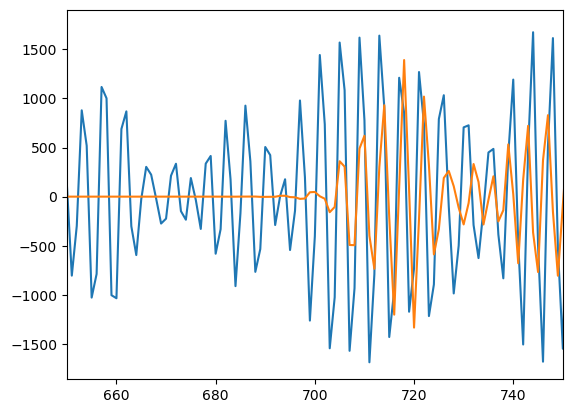

In [19]:
plt.plot(RFs[:, 0, 0])
plt.plot(RFs[:, 0, -1])
plt.xlim(650, 750)